In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor# tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # l]ayers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.utils.data import DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from my_funcs import * 

In [2]:
#Load data
trainD = pd.read_csv('digit-recognizer/train.csv')
#testD = pd.read_csv('digit-recognizer/test.csv')
#sampleD = pd.read_csv('digit-recognizer/sample_submission.csv')
trainD.shape

(42000, 785)

In [3]:
y_train = trainD['label']
X_train = trainD.drop(['label'],1,inplace=False).values/255

In [11]:
print(torch.cuda.is_available())
device = torch.device('cuda')     # Default CUDA device

True


In [45]:
from sklearn.model_selection import train_test_split
testSize = 1.0/5
featuresTrain, featuresTest, targetsTrain, targetsTest = train_test_split(X_train, y_train.values, test_size=testSize, random_state=42)
testLen = len(targetsTest)
print("The length of test data is {}".format(testLen))


featuresTrain = torch.from_numpy(featuresTrain).type(torch.float32)
#featuresTrain = featuresTrain.to(device) #not sure if it is better memory managment to do so BEFORE the dataloader

featuresTest = torch.from_numpy(featuresTest).type(torch.float32)
#featuresTest = featuresTest.to(device)

targetsTrain = torch.from_numpy(targetsTrain).type(torch.LongTensor)
#targetsTrain = targetsTrain.to(device)

targetsTest = torch.from_numpy(targetsTest).type(torch.LongTensor)
#targetsTest = targetsTest.to(device)

featuresSize = 28*28
targetsSize = 10

# batch_size, epoch and iteration
batch_size = 420
n_iters = 10000
num_epochs = n_iters / (len(featuresTrain) / batch_size)
num_epochs = int(num_epochs)
print("The number of epochs is {}".format(num_epochs))

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

The length of test data is 8400
The number of epochs is 125


In [50]:
#divisors = div(40768/784)
number = testSize*42000
print(int(number))
divisors = div(number)
prime_Divisors = pDiv(number)
print(prime_Divisors)
print(np.sort(divisors))


8400
[[1, 2, 3, 5, 7], [1, 4, 1, 2, 1]]
[   1    2    3    4    5    6    7    8   10   12   14   15   16   20
   21   24   25   28   30   35   40   42   48   50   56   60   70   75
   80   84  100  105  112  120  140  150  168  175  200  210  240  280
  300  336  350  400  420  525  560  600  700  840 1050 1200 1400 1680
 2100 2800 4200 8400]


In [4]:
# Create convolutional network Model
class conVolNN(nn.Module):
        
    def __init__(self, hidden_layer, output_dim):
        super(conVolNN, self).__init__()
        # First convolutional layer: 
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = hidden_layer[0], kernel_size = 3, stride = 1,padding=1)
        self.ac1 = nn.ReLU() 
        self.conv11 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[0], kernel_size = 3, stride = 1, padding = 1)
        self.ac11 = nn.ReLU() 
        #self.conv12 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[0], kernel_size = 3, stride = 1)
        #self.ac12 = nn.ReLU() 
        self.pool1 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],28,28) to (N,hidden_layer[0],14,14)
        #self.drop1 = nn.Dropout2d(p = 0.1)
        
        # Second convolutional layer:
        self.conv2 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[1], kernel_size = 5, stride = 1, padding = 2)                                                
        self.ac2 = nn.ReLU()
        self.conv21 = nn.Conv2d(in_channels= hidden_layer[1], out_channels = hidden_layer[1], kernel_size = 5, stride = 1, padding = 2)
        self.ac21 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[1],14,14) to (N,hidden_layer[1],7,7)
        #self.drop2 = nn.Dropout2d(p = 0.2)
        
        # Third convolutional layer:
        self.conv3 = nn.Conv2d(in_channels= hidden_layer[1], out_channels = hidden_layer[2], kernel_size = 7, stride = 1, padding = 3)                                                
        self.ac3 = nn.ReLU()
        self.conv31 = nn.Conv2d(in_channels= hidden_layer[2], out_channels = hidden_layer[2], kernel_size = 7, stride = 1, padding = 3)
        self.ac31 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride = 3) #(N,hidden_layer[2],7,7) to (N,hidden_layer[2],2,2)
                                
        # Forth convolutional layer:
        self.conv4 = nn.Conv2d(in_channels= hidden_layer[2], out_channels = hidden_layer[3], kernel_size = 7, stride = 1, padding = 3)
        self.batch4 = nn.BatchNorm2d(hidden_layer[3])
        self.ac4 = nn.ReLU()#(N,hidden_layer[0],5,5) to (N,hidden_layer[1],4,4)
        #self.pool3 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],4,4) to (N,hidden_layer[0],2,2)
        
        #Final Layers
        self.f5 = nn.Linear(hidden_layer[3]*2*2,hidden_layer[3])
        self.ac5 = nn.ReLU()
        self.drop5 = nn.Dropout2d(p = 0.5)
        self.f51 = nn.Linear(hidden_layer[3],hidden_layer[4])
        self.ac51 = nn.ReLU()
        self.drop51 = nn.Dropout2d(p = 0.5)
        self.f52 = nn.Linear(hidden_layer[4],output_dim)
        
        
        
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.ac1(out)
        #print(out.shape)
        out = self.conv11(out)
        out = self.ac11(out)
        #print(out.shape)
        out = self.pool1(out)
        #print(out.shape)
        
        out = self.conv2(out)
        out = self.ac2(out)
        #print(out.shape)
        out = self.conv21(out)
        out = self.ac21(out)
       # print(out.shape)
        out = self.pool2(out)
        #print(out.shape)
        
        out = self.conv3(out)
        out = self.ac3(out)
        #print(out.shape)
        out = self.conv31(out)
        out = self.ac31(out)
        #print(out.shape)
        out = self.pool3(out)
        #print(out.shape)
                                
        out = self.conv4(out)
        #print(out.shape)
        out = self.batch4(out)
        out = self.ac4(out)
        #
        #print(out.shape)
        
        out = out.view(out.size(0),-1) # Don't forget to flatten before the final linear transformation.
        out = self.f5(out) #The logistic transformation is on the loss function.
        out = self.ac5(out)
        out = self.drop5(out)
        out = self.f51(out) #The logistic transformation is on the loss function.
        out = self.ac51(out)
        out = self.drop51(out)
        out = self.f52(out) #The logistic transformation is on the loss function.
        return out
    


In [ ]:
# Create ANN
model = conVolNN([32,64,128,256,100],targetsSize)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,25,37,50], gamma=0.75)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=8, 
                                             verbose=True, threshold=0.00001, threshold_mode='rel',
                                             cooldown=1, min_lr=1e-8, eps=1e-08)

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

In [54]:
#%%time
# CNN model training
model.to(device)
with torch.cuda.device(0):
    for epoch in range(num_epochs):
        if(epoch % 5==0): print(epoch)
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            train = Variable(images.view(batch_size,1,28,28))
            labels = Variable(labels)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and ross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            
            optimizer.step()
            count += 1
            if count % 60 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:

                    images = images.to(device)
                    labels = labels.to(device)
                    test = Variable(images.view(batch_size,1,28,28))

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    correct += (predicted == labels).sum()

                accuracy = 100 * float(correct) / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                if (count) % 500 == 0:
                    # Print Loss
                    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count+1, loss.item(), accuracy))

        scheduler.step(accuracy)                 
print(np.mean(accuracy_list[len(accuracy_list)+1-int(n_iters/100):]), np.std(accuracy_list[len(accuracy_list)+1-int(n_iters/100):]))

0
5
10
15
Iteration: 1501  Loss: 0.0016306252218782902  Accuracy: 98.92857142857143 %
20
25
30
Epoch    32: reducing learning rate of group 0 to 7.5000e-02.
35
Iteration: 3001  Loss: 0.001410776050761342  Accuracy: 99.08333333333333 %
40
Epoch    42: reducing learning rate of group 0 to 5.6250e-02.
45
50
55
Iteration: 4501  Loss: 0.0006137870368547738  Accuracy: 99.11904761904762 %
Epoch    58: reducing learning rate of group 0 to 4.2188e-02.
60
65
70
Iteration: 6001  Loss: 0.0003254776820540428  Accuracy: 99.14285714285714 %
Epoch    74: reducing learning rate of group 0 to 3.1641e-02.
75
80
Epoch    84: reducing learning rate of group 0 to 2.3730e-02.
85
90
Iteration: 7501  Loss: 0.001543909078463912  Accuracy: 99.08333333333333 %
95
100
Epoch   101: reducing learning rate of group 0 to 1.7798e-02.
105
110
Epoch   111: reducing learning rate of group 0 to 1.3348e-02.
Iteration: 9001  Loss: 0.0009369214531034231  Accuracy: 99.10714285714286 %
115
120
Epoch   121: reducing learning rat

In [8]:
testD = pd.read_csv('digit-recognizer/test.csv')
X_test = testD.values/255


X_test = torch.from_numpy(X_test).type(torch.float32)

In [9]:
len(X_test)
# batch_size, epoch and iteration
batch_size = 500

In [15]:

#print("The number of epochs is {}".format(num_epochs))
submission_file = open('submission_file.txt',"w+") 
submission_file.write("ImageId,Label\n")
test = torch.utils.data.TensorDataset(X_test)

test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
loaded_model.to(device)
id = 1
with torch.cuda.device(0):
    for i, images in enumerate(test_loader):
            #print(images)
            to_Test = Variable(images[0].view(batch_size,1,28,28))
            to_Test = to_Test.to(device)
            # Forward propagation
            outputs = loaded_model(to_Test)
            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            for prediction in predicted:
                #print(id,prediction.item())
                submission_file.write("{},{}\n".format(id,prediction.item()))
                id+=1
                
                
                
submission_file.close() 

In [80]:
500*56

28000

Epoch, median, std
41 99.11309523809524 3.826244463098002
83 99.14285714285714 0.10020948579392941
125 99.1547619047619 0.05569926228199614


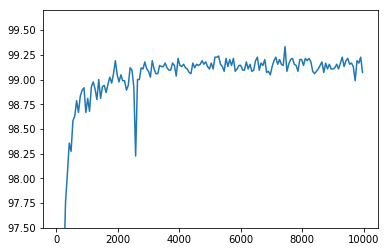

In [58]:
plt.plot(iteration_list,accuracy_list)
plt.ylim(97.5,99.7)
avgSec(accuracy_list)

In [6]:
PATH = "./candidate_Model"
#torch.save(model.state_dict(), "./candidate_Model")
loaded_model = conVolNN([32,64,128,256,100],10)
loaded_model.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
len(train_loader)
len(featuresTrain)

33600

In [57]:

#Helper function to calculate the average accuracy of the last training run.
def avgSec(array):
        distance = 60
        print("Epoch, median, std")
        for i in range(0,int(count/2/distance),int(n_iters/4/distance)):
            print(int(num_epochs/3*(i/int(n_iters/distance/4)+1)), np.median(accuracy_list[i:i+n_iters]),np.std(accuracy_list[i:i+n_iters]))
            
#avgSec(accuracy_list)


In [29]:
# Create convolutional network Model
class conVolNN(nn.Module):
        
    def __init__(self, hidden_layer, output_dim):
        super(conVolNN, self).__init__()
        # First convolutional layer: 
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = hidden_layer[0], kernel_size = 5, stride = 1, padding = 0)
        self.ac1 = nn.ReLU() #One image object in (N,C,H,W). (N,1,28,28) to (N,hidden_layer[0],24,24)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],24,24) to (N,hidden_layer[0],12,12)
        
        # Second convolutional layer:
        self.conv2 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[1], kernel_size = 3, stride = 1, padding = 0)
        self.ac2 = nn.ReLU()#(N,hidden_layer[0],12,12) to (N,hidden_layer[1],10,10)
        self.pool2 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],10,10) to (N,hidden_layer[0],5,5)
        
        # Third convolutional layer:
        self.conv3 = nn.Conv2d(in_channels= hidden_layer[1], out_channels = hidden_layer[2], kernel_size = 2, stride = 1, padding = 0)
        self.ac3 = nn.ReLU()#(N,hidden_layer[0],5,5) to (N,hidden_layer[1],4,4)
        self.pool3 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],4,4) to (N,hidden_layer[0],2,2)
        
        #Final Layer
        self.f = nn.Linear(hidden_layer[2]*2*2,hidden_layer[3])
        self.fac = nn.Sigmoid()
        self.f1 = nn.Linear(hidden_layer[3],output_dim)
        
        
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.ac1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.ac2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.ac3(out)
        out = self.pool3(out)
        out = out.view(out.size(0),-1) # Don't forget to flatten before the final linear transformation.
        out = self.f(out) #The logistic transformation is on the loss function.
        out = self.fac(out)
        out = self.f1(out) #The logistic transformation is on the loss function.
        return out
    
    
    # Create ANN
model = conVolNN([32,32,16,200],targetsSize)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

count = 0
loss_list = []
iteration_list = []
accuracy_list = []


In [30]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(batch_size,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(batch_size,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if (count) % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count+1, loss.item(), accuracy))

RuntimeError: shape '[500, 1, 28, 28]' is invalid for input of size 313600